In [1]:
# !conda install -c pyviz hvplot

In [2]:
# !conda install numpy

In [3]:
# !conda install -c intel mkl

Reference: https://www.kaggle.com/prasun2106/google-or-tools-w-clusters

In [1]:
# from tqdm import tqdm
import numpy as np
import pandas as pd
# from sympy import sieve
# import hvplot.pandas #custom
# import colorcet as cc
from sklearn.mixture import GaussianMixture

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cities = pd.read_csv('cities.csv')

In [4]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197769 entries, 0 to 197768
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CityId  197769 non-null  int64  
 1   X       197769 non-null  float64
 2   Y       197769 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 4.5 MB


In [5]:
cities.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [6]:
cities.isna().sum()

CityId    0
X         0
Y         0
dtype: int64

In [7]:
cluster_model = GaussianMixture(n_components = 10, verbose = 1 )

In [8]:
cities['mclust'] = cluster_model.fit_predict(cities[['X','Y']].values)

Initialization 0
  Iteration 10
Initialization converged: True


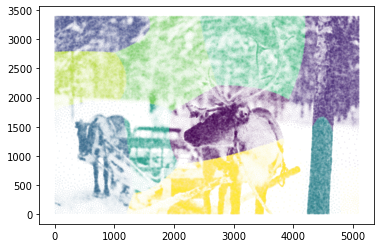

In [9]:
plt.scatter(cities['X'],cities['Y'],s = 0.002, c= cities['mclust'])

In [10]:
# Reducing number of locations to clients requirement
cities = cities.iloc[0:10000,0:10000]

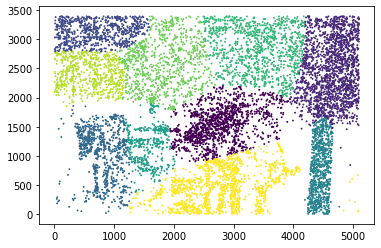

In [11]:
plt.scatter(cities['X'],cities['Y'], s = 0.8, c= cities['mclust'])

In [12]:
# randomly sampling dataset to make it smaller
cities = cities.sample(n = 10000, random_state = 10 )

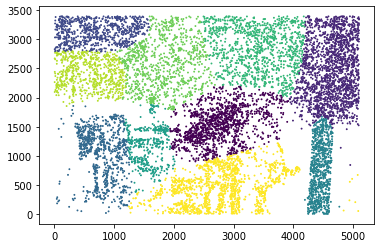

In [13]:
plt.scatter(cities['X'],cities['Y'],s = 0.8, c= cities['mclust'])

In [14]:
# Assigning randomly 100 clusters using GMM
cluster_model = GaussianMixture(n_components = 100, verbose = 1 )
cities['mclust'] = cluster_model.fit_predict(cities[['X','Y']].values)

Initialization 0
  Iteration 10
Initialization converged: True


<BarContainer object of 100 artists>

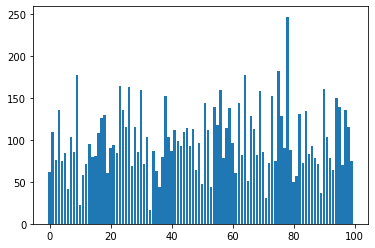

In [15]:
# plotting the number of points assigned to each cluster
plt.bar(cities['mclust'].unique(), cities['mclust'].value_counts().reset_index(drop = True))

## Finding Geometric Center for each 100 clusters

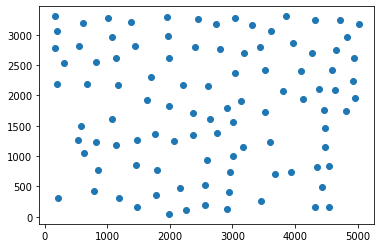

In [16]:
plt.scatter(x = cities.groupby(by = 'mclust')[['X','Y']].mean()['X'],y =  cities.groupby(by = 'mclust')[['X','Y']].mean()['Y'])

In [17]:
cities_center = cities.groupby('mclust')['Y'].mean().reset_index().merge(cities.groupby('mclust')['X'].mean().reset_index(), how = 'inner')

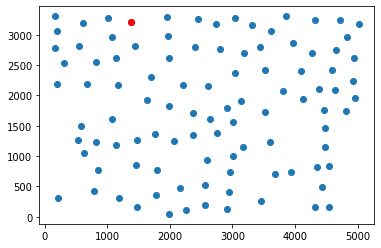

In [18]:
# Case 1:single depot
plt.scatter(cities_center['X'], cities_center['Y'])
plt.scatter(cities_center['X'][8], cities_center['Y'][8], c = 'red')

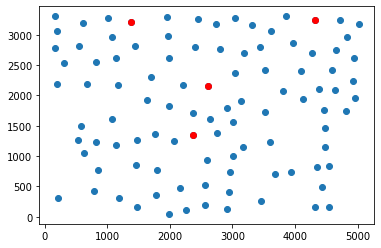

In [19]:
# Case 2: index 0,5,8,9 are selected as the depot at random
plt.scatter(cities_center['X'], cities_center['Y'])
plt.scatter(cities_center['X'][[0,5,8,9]], cities_center['Y'][[0,5,8,9]], c = 'red')

# Solving a VRP problem using Google OR Tools - Single Depot [index 8]

In [23]:
def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [24]:
# # # create distance matrix
# distance_matrix = pd.DataFrame(np.nan, index = np.arange(0,100), columns =np.arange(0,100))
# # dist = []
# for cluster1 in cities_center['mclust']:
#     for cluster2 in cities_center['mclust']:
#         x1 = list(cities_center[cities_center['mclust']==cluster1]['X'])[0]
#         x2 = list(cities_center[cities_center['mclust']==cluster2]['X'])[0]
#         y1 = list(cities_center[cities_center['mclust']==cluster1]['Y'])[0]
#         y2 = list(cities_center[cities_center['mclust']==cluster1]['Y'])[0]
# #         dist.append(distance(x1,y1,x2,y2))
#         distance_matrix.iloc[cluster1,cluster2] = distance(x1,y1,x2,y2)

In [25]:
# Following Google OR
# distance_matrix_array = np.array(distance_matrix)

The data consists of:

* distance_matrix: An array of distances between locations on meters.
* num_locations: The number of locations.
* num_vehicles: The number of vehicles in the fleet.
* depot: The index of the depot, the location where all vehicles start and end their routes.

client stats- 125 trucks per day, approx 4350 order per week, 10000 active locations

In [26]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from scipy.spatial.distance import pdist, squareform

In [27]:
locations = cities_center[['X','Y']].values

In [28]:
# distance matrix - 100*100 as output, input - x and y coordinate of all 100 city centers
def create_mat(df):
    mat = pdist(locations)
    return squareform(mat)

In [29]:
# distance callback -for google or - takes input as distance matrix, from node and to node - output distance between nodes
def create_distance_callback(dist_matrix):
    def distance_callback(from_node, to_node):
        return int(dist_matrix[from_node][to_node])
    return distance_callback

In [30]:
distance_matrix_array = create_mat(locations)

In [35]:
# DIrectly taken from Google OR tools guide page
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))




def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Route for vehicle 0:
 0 ->  8 ->  6 ->  2 ->  5 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 2:
 0 ->  9 ->  10 ->  16 ->  14 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  12 ->  11 ->  15 ->  13 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1552m


In [ ]:
# Functions
# Create data
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix_array
    data['num_vehicles'] = 10
    data['depot'] = 15
    return data

#function for printing solution
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

# main function

def main():
    data = create_data_model()
    
    # create routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    
    # create routing model
    routing = pywrapcp.RoutingModel(manager)
    
    # create transit call back
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node, to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    #define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
# Add distance constraint
# To solve this VRP, you need to create a distance dimension, 
# which computes the cumulative distance traveled by each vehicle along its route. You can then set
# a cost proportional to the maximum of the total distances along each route. 
# Routing programs use dimensions to keep track of quantities that accumulate over a 
# vehicle's route. 
# The following code creates the distance dimension, using the solver's AddDimension method. 
# The argument transit_callback_index is the index for the distance_callback.
    
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0, # slack max
        1500, # vehicle maximum travel distance - set it to a large number
        True, # start at t = 0
        dimension_name)
    # confusion over these two lines
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    
     # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()
    
        

In [128]:
status_dict ={0: 'ROUTING_NOT_SOLVED', 
               1: 'ROUTING_SUCCESS', 
               2: 'ROUTING_FAIL',
               3: 'ROUTING_FAIL_TIMEOUT',
               4: 'ROUTING_INVALID'}

In [132]:
def optimize(df, startnode=None, stopnode=None, fixed=False):     
    num_nodes = df.shape[0]
    mat = create_mat(df)
    dist_callback = create_distance_callback(mat)
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
# search_parameters.time_limit_ms = int(1000*60*numminutes)
    search_parameters.solution_limit = num_iters 
    search_parameters.first_solution_strategy = (
                                    routing_enums_pb2.FirstSolutionStrategy.SAVINGS)
    search_parameters.local_search_metaheuristic = (
                            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)

    if fixed:
        routemodel = pywrapcp.RoutingModel(num_nodes, 1, [startnode], [stopnode])
    else:
        routemodel = pywrapcp.RoutingModel(num_nodes, 1, startnode)
    routemodel.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    
    print("optimizing {} cities".format(num_nodes)) 
    assignment = routemodel.SolveWithParameters(search_parameters)

    print("status: ", status_dict.get(routemodel.status()))
    print("travel distance: ",  str(assignment.ObjectiveValue()), "\n")
    return routemodel, assignment

In [133]:
def get_route(df, startnode, stopnode, fixed): 
    routemodel, assignment = optimize(df, int(startnode), int(stopnode), fixed)
    route_number = 0
    node = routemodel.Start(route_number)
    route = []
    while not routemodel.IsEnd(node):
        route.append(node) 
        node = assignment.Value(routemodel.NextVar(node))
    return route

In [134]:
%%time
#%% parameters
num_iters=100

# main
nnode = int(cities.loc[0, 'mclust'])
locations = cities_center[['X', 'Y']].values
segment = get_route(locations, nnode, 0, fixed=False)

AttributeError: type object 'RoutingModel' has no attribute 'DefaultSearchParameters'

In [92]:
nnode = cities_center.loc[8,'mclust']

In [94]:
locations = cities_center[['X', 'Y']].values

In [98]:
# parameter
num_iters = 100

In [99]:
from scipy.spatial.distance import pdist, squareform
# distance matrix
def create_mat(locations)

In [29]:
# Functions
# Create data
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix_array
    data['num_vehicles'] = 4
    data['depot'] = 15
    return data

#function for printing solution
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

# main function

def main():
    data = create_data_model()
    
    # create routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    
    # create routing model
    routing = pywrapcp.RoutingModel(manager)
    
    # create transit call back
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node, to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    #define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
# Add distance constraint
# To solve this VRP, you need to create a distance dimension, 
# which computes the cumulative distance traveled by each vehicle along its route. You can then set
# a cost proportional to the maximum of the total distances along each route. 
# Routing programs use dimensions to keep track of quantities that accumulate over a 
# vehicle's route. See Dimensions for more details.
# The following code creates the distance dimension, using the solver's AddDimension method. 
# The argument transit_callback_index is the index for the distance_callback.
    
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0, # slack max
        10000, # vehicle maximum travel distance - set it to a large number
        True, # start at t = 0
        dimension_name)
    # confusion over these two lines
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    
     # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()
    
        

Route for vehicle 0:
 15 ->  82 ->  14 ->  38 ->  6 ->  39 ->  23 ->  12 ->  68 ->  49 ->  19 ->  73 ->  22 ->  13 ->  0 ->  10 ->  59 ->  46 ->  21 ->  5 ->  74 ->  53 ->  32 ->  27 ->  11 ->  70 ->  17 ->  9 ->  36 ->  25 ->  2 ->  89 ->  4 ->  31 ->  67 ->  8 ->  48 ->  18 ->  87 ->  66 ->  55 ->  29 ->  77 ->  26 ->  85 ->  83 ->  90 ->  54 ->  52 ->  16 ->  50 ->  7 ->  94 ->  51 ->  61 ->  57 ->  81 ->  34 ->  45 ->  95 ->  41 ->  20 ->  76 ->  44 ->  69 ->  65 ->  1 ->  88 ->  97 ->  96 ->  91 ->  92 ->  72 ->  37 ->  75 ->  33 ->  79 ->  58 ->  30 ->  47 ->  98 ->  78 ->  80 ->  62 ->  99 ->  86 ->  40 ->  71 ->  64 ->  56 ->  63 ->  60 ->  28 ->  3 ->  24 ->  93 ->  35 ->  84 -> 15
Distance of the route: 9624m

Route for vehicle 1:
 15 ->  42 ->  43 -> 15
Distance of the route: 161m

Route for vehicle 2:
 15 -> 15
Distance of the route: 0m

Route for vehicle 3:
 15 -> 15
Distance of the route: 0m

Maximum of the route distances: 9624m


In [26]:
# Sample code directly taken from Google OR for solving VRP with different starting and ending points


"""Simple Vehicles Routing Problem."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 4
    data['starts'] = [1, 2, 15, 16]
    data['ends'] = [0, 0, 0, 0]
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        2000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Route for vehicle 0:
 1 ->  4 ->  3 ->  7 -> 0
Distance of the route: 1004m

Route for vehicle 1:
 2 ->  6 ->  8 ->  5 -> 0
Distance of the route: 936m

Route for vehicle 2:
 15 ->  11 ->  12 ->  13 -> 0
Distance of the route: 936m

Route for vehicle 3:
 16 ->  14 ->  10 ->  9 -> 0
Distance of the route: 1118m

Maximum of the route distances: 1118m
